# Base OWID
Focus on minimal case dataset.

* date

* country
* country_code
* country_id

* continent
* region -- sub-contintent but larger than country

* new_cases
* new_deaths
* new_tests


In [1]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
%matplotlib inline

# Params

In [2]:
owid_dataset = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

base_owid_dataset = '../../data/base_owid.pkl'

# The columns used in the base representation
base_cols = [
    'date', 'country', 'country_code', 'country_id', 'continent', 'region', 
    'new_cases', 'new_deaths', 'new_tests_smoothed', 
    'population'
]


# The Our World in Data Dataset

## Load the OWID Dataset 

In [3]:
logger.info('Loading OWID dataset @ %s' % owid_dataset)

owid = pd.read_csv(owid_dataset, parse_dates=['date'], low_memory=False)
owid.shape, owid.location.nunique(), owid.columns, owid.date.max()

2020-09-15 09:16:12.973 | INFO     | __main__:<module>:1 - Loading OWID dataset @ https://covid.ourworldindata.org/data/owid-covid-data.csv


((43705, 41),
 212,
 Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
        'new_cases_smoothed', 'total_deaths', 'new_deaths',
        'new_deaths_smoothed', 'total_cases_per_million',
        'new_cases_per_million', 'new_cases_smoothed_per_million',
        'total_deaths_per_million', 'new_deaths_per_million',
        'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
        'total_tests_per_thousand', 'new_tests_per_thousand',
        'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
        'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
        'population', 'population_density', 'median_age', 'aged_65_older',
        'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
        'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
        'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
        'life_expectancy', 'human_development_index'],
       dtype='object'),
 Times

In [4]:
owid = owid.rename(columns={
    'iso_code': 'country_code',
    'location': 'country'
})

owid.date.max()

Timestamp('2020-09-14 00:00:00')

In [5]:
# Drop disputed Kosovo because it causes problems with country codes later
owid = owid[owid['country']!='Kosovo']

# Drop Falklands because they are without a region
owid = owid[owid['country']!='Falkland Islands']

# Drop missing country codes
owid = owid.dropna(subset=['country_code'])

owid.shape, owid.country.nunique()

((43097, 41), 209)

## Add the 2 letter codes as `country_id`

In [6]:
def lookup_country_code(code, **kwargs):
    country = pycountry.countries.get(**kwargs)
    
    if country: return getattr(country, code)


owid['country_id'] = owid['country_code'].apply(
    lambda country_code: lookup_country_code('alpha_2', alpha_3=country_code)
)

owid = owid[owid['country_id'].notnull()]

owid.shape, owid.country.nunique()

((42838, 42), 208)

## Add Regions

In [7]:
# regions = {
#     'northern_america': ['United States', 'Canada', 'Mexico', 'Greenland'],
    
#     'central_america': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    
#     'carribean': [
#         'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Bermuda', 'British Virgin Islands', 
#         'Cayman Islands', 'Cuba', 'Curacao', 'Dominica', 'Dominican Republic', 'Grenada', 'Guadeloupe', 'Haiti', 
#         'Jamaica', 'Martinique', 'Montserrat', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Sint Maarten (Dutch part)',
#         'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States Virgin Islands', 
#         'Bonaire Sint Eustatius and Saba', 'Turks and Caicos Islands'],
    
#     'caribbean_republics ': ['Colombia', 'Venezuela', 'Guyana', 'Suriname', 'French Guiana'],
    
#     'andean_republics': ['Bolivia', 'Ecuador', 'Chile', 'Colombia', 'Peru'],
    
#     'river_plate_republics': ['Uruguay', 'Paraguay', 'Argentina', 'Brazil'],

        
#     'non-eu': [
#         'Faeroe Islands', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey', 'Norway', 'United Kingdom',
#         'Albania', 'Andorra', 'Bosnia and Herzegovina', 'Gibraltar', 'Macedonia', 'Montenegro',
#         'San Marino', 'Serbia', 'Vatican', 'Belarus', 'Moldova',
#         'Russia', 'Ukraine', 'Switzerland', 'Liechtenstein', 'Monaco'
#     ],
    
#     'eu': [
#         'Austria', 'Belgium', 'Bulgaria', 'Croatia','Cyprus', 'Czech Republic', 'Denmark', 
#         'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
#         'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
        
#     ],
    
#     'north_africa': [
#         'Algeria' ,'Canary Islands' ,'Ceuta' ,'Egypt' ,'Libya' ,
#         'Madeira' ,'Melilla' ,'Morocco' ,'Sahrawi Arab Democratic Republic' ,
#         'Sudan' ,'Tunisia'
#     ],

#     'east_africa': [
#         'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'French Southern Territories', 
#         'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mayotte', 'Mozambique', 'Reunion', 
#         'Rwanda', 'Seychelles', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda', 
#         'Zambia', 'Zimbabwe', 
#     ],

#     'central_africa': [
#         'Angola', 'Cameroon', 'Central African Republic', 'Chad', 
#         'Democratic Republic of Congo', 'Congo', 
#         'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe'
#     ],

#     'west_africa': [
#         'Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 
#         'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 
#         'Saint Helena, Ascension and Tristan da Cunha', 'Senegal', 'Sierra Leone', 'Togo',
#         'Western Sahara'
#     ],

#     'southern_africa': [
#         'Botswana', 'Swaziland', 'Lesotho', 'Namibia', 'South Africa'
#     ],
    
#     'central_asia': ['Tajikistan', 'Uzbekistan', 'Kazakhstan', 'Turkmenistan', 'Kyrgyzstan'],
    
#     'east_asia': ['China', 'Mongolia', 'North Korea', 'South Korea', 'Japan', 'Hong Kong', 'Taiwan', 'Macau'],
    
#     'south_asia': ['Sri Lanka', 'Bangladesh', 'India', 'Afghanistan', 'Pakistan', 'Bhutan', 'Nepal', 'Maldives'],
    
#     'south_east_asia': ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines','Singapore', 'Thailand', 'Timor', 'Vietnam', 'Christmas Island', 'Cocos Islands'],
    
#     'western_asia': ['Georgia', 'Armenia', 'Azerbaijan', 'Turkey'],
    
#     'middle_east': ['Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen'],
 
#     'australasia': ['Australia', 'New Zealand'],
    
#     'melanesia_micronesia_polynesia': [
        
#         # melanesia
#         'Fiji', 'New Caledonia', 'Papua New Guinea', 'Solomon Islands', 'Vanuatu',
    
#         # micronesia
#         'Guam', 'Kiribati', 'Marshall Islands', 'Micronesia (Federated States of)', 
#         'Nauru', 'Northern Mariana Islands', 'Palau', 'United States Minor Outlying Islands',
        
#         # polynesia
#         'American Samoa', 'Cook Islands', 'Easter Island', 'French Polynesia', 
#         'Niue', 'Norfolk Island', 'Pitcairn Islands', 'Samoa', 
#         'Tokelau', 'Tonga', 'Tuvalu', 'Wallis and Futuna','Rotuma Rotuma'
#     ],

# }

In [8]:
owid['region'] = None

### The Americas

In [9]:
north_america = {
    'northern_america': ['United States', 'Canada', 'Mexico', 'Greenland'],
    
    'central_america': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    
    'carribean': [
        'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Bermuda', 'British Virgin Islands', 
        'Cayman Islands', 'Cuba', 'Curacao', 'Dominica', 'Dominican Republic', 'Grenada', 'Guadeloupe', 'Haiti', 
        'Jamaica', 'Martinique', 'Montserrat', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Sint Maarten (Dutch part)',
        'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States Virgin Islands', 
        'Bonaire Sint Eustatius and Saba', 'Turks and Caicos Islands']
}



for label,countries in north_america.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 carribean           25
 central_america      7
 northern_america     4
 Name: country, dtype: int64,
 172)

In [10]:
south_america = {
    
    'caribbean_republics ': ['Colombia', 'Venezuela', 'Guyana', 'Suriname', 'French Guiana'],
    
    'andean_republics': ['Bolivia', 'Ecuador', 'Chile', 'Colombia', 'Peru'],
    
    'river_plate_republics': ['Uruguay', 'Paraguay', 'Argentina', 'Brazil'],
}


for label,countries in south_america.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()
    

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_america           7
 northern_america          4
 river_plate_republics     4
 Name: country, dtype: int64,
 160)

### Europe

In [11]:
europe = {
#     'northern_europe': [
#         'Denmark', 'Estonia', 'Faeroe Islands', 'Finland',
#        'Guernsey', 'Iceland', 'Ireland', 'Isle of Man', 'Jersey',
#        'Latvia', 'Lithuania', 'Norway', 'Sweden', 'United Kingdom'
#     ],
    
#     'southern_europe': [
#         'Albania', 'Andorra', 'Bosnia and Herzegovina', 'Croatia',
#        'Gibraltar', 'Greece', 'Italy', 'Macedonia', 'Malta', 'Montenegro',
#        'Portugal', 'San Marino', 'Serbia', 'Slovenia', 'Spain', 'Vatican'
#     ],
    
#     'eastern_europe': [
#         'Belarus', 'Bulgaria', 'Czech Republic', 'Hungary', 'Moldova',
#        'Poland', 'Romania', 'Russia', 'Slovakia', 'Ukraine'
#     ],
    
#     'western_europe': [
#         'Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein',
#        'Luxembourg', 'Monaco', 'Netherlands', 'Switzerland'
#     ],
    
    'non-eu': {
        'Faeroe Islands', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey', 'Norway', 'United Kingdom',
        'Albania', 'Andorra', 'Bosnia and Herzegovina', 'Gibraltar', 'Macedonia', 'Montenegro',
        'San Marino', 'Serbia', 'Vatican', 'Belarus', 'Moldova',
        'Russia', 'Ukraine', 'Switzerland', 'Liechtenstein', 'Monaco'
    },
    
    'eu': {
        'Austria', 'Belgium', 'Bulgaria', 'Croatia','Cyprus', 'Czech Republic', 'Denmark', 
        'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
        'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
        
    }
    
    
}


for label,countries in europe.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_america           7
 eu                       27
 non-eu                   23
 northern_america          4
 river_plate_republics     4
 Name: country, dtype: int64,
 110)

### Africa's Regions

In [12]:
owid['continent'] = np.where(owid['country']=='Egypt', 'Asia', owid['continent'])

In [13]:
africa = {
    'north_africa': [
        'Algeria' ,'Canary Islands' ,'Ceuta' ,'Egypt' ,'Libya' ,
        'Madeira' ,'Melilla' ,'Morocco' ,'Sahrawi Arab Democratic Republic' ,
        'Sudan' ,'Tunisia'
    ],

    'east_africa': [
        'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'French Southern Territories', 
        'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mayotte', 'Mozambique', 'Reunion', 
        'Rwanda', 'Seychelles', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda', 
        'Zambia', 'Zimbabwe', 
    ],

    'central_africa': [
        'Angola', 'Cameroon', 'Central African Republic', 'Chad', 
        'Democratic Republic of Congo', 'Congo', 
        'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe'
    ],

    'west_africa': [
        'Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 
        'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 
        'Saint Helena, Ascension and Tristan da Cunha', 'Senegal', 'Sierra Leone', 'Togo',
        'Western Sahara'
    ],

    'southern_africa': [
        'Botswana', 'Swaziland', 'Lesotho', 'Namibia', 'South Africa'
    ],
}

for label,countries in africa.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        
owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_africa            9
 central_america           7
 east_africa              18
 eu                       27
 non-eu                   23
 north_africa              6
 northern_america          4
 river_plate_republics     4
 southern_africa           5
 west_africa              17
 Name: country, dtype: int64,
 55)

### Asia's Regions

In [14]:
# Adjust Cyprus
owid['continent'] = np.where(owid['country']=='Cyprus', 'Asia', owid['continent'])

In [15]:
asia = {
    'central_asia': ['Tajikistan', 'Uzbekistan', 'Kazakhstan', 'Turkmenistan', 'Kyrgyzstan'],
    
    'east_asia': ['China', 'Mongolia', 'North Korea', 'South Korea', 'Japan', 'Hong Kong', 'Taiwan', 'Macau'],
    
    'south_asia': ['Sri Lanka', 'Bangladesh', 'India', 'Afghanistan', 'Pakistan', 'Bhutan', 'Nepal', 'Maldives'],
    
    'south_east_asia': ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines','Singapore', 'Thailand', 'Timor', 'Vietnam', 'Christmas Island', 'Cocos Islands'],
    
    'western_asia': ['Georgia', 'Armenia', 'Azerbaijan', 'Turkey'],
    
    'middle_east': ['Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen'],

    
}


for label,countries in asia.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_africa            9
 central_america           7
 central_asia              4
 east_africa              18
 east_asia                 6
 eu                       27
 middle_east              15
 non-eu                   23
 north_africa              5
 northern_america          4
 river_plate_republics     4
 south_asia                8
 south_east_asia          11
 southern_africa           5
 west_africa              17
 western_asia              4
 Name: country, dtype: int64,
 8)

In [16]:
# Adjust Georgia to avoid name clash with US state else where.
owid['country'] = np.where(owid['country']=='Georgia', 'Georgia (W. Asia)', owid['country'])

### Oceania's Regions

In [17]:
oceania = {
    'australasia': ['Australia', 'New Zealand'],
    
    'melanesia_micronesia_polynesia': [
        
        # melanesia
        'Fiji', 'New Caledonia', 'Papua New Guinea', 'Solomon Islands', 'Vanuatu',
    
        # micronesia
        'Guam', 'Kiribati', 'Marshall Islands', 'Micronesia (Federated States of)', 
        'Nauru', 'Northern Mariana Islands', 'Palau', 'United States Minor Outlying Islands',
        
        # polynesia
        'American Samoa', 'Cook Islands', 'Easter Island', 'French Polynesia', 
        'Niue', 'Norfolk Island', 'Pitcairn Islands', 'Samoa', 
        'Tokelau', 'Tonga', 'Tuvalu', 'Wallis and Futuna','Rotuma Rotuma'
    ],
    
}


for label,countries in oceania.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby(['continent', 'region'])['country'].nunique(),  owid.groupby(['continent'])['country'].nunique(), owid[owid['region'].isnull()].country.nunique()

(continent      region                        
 Africa         central_africa                     9
                east_africa                       18
                north_africa                       5
                southern_africa                    5
                west_africa                       17
 Asia           central_asia                       4
                east_asia                          6
                eu                                 1
                middle_east                       15
                south_asia                         8
                south_east_asia                   11
                western_asia                       4
 Europe         eu                                26
                non-eu                            23
 North America  carribean                         25
                central_america                    7
                northern_america                   4
 Oceania        australasia                        2

In [18]:
owid[owid['region'].isnull()].country.unique(), owid.country.nunique()

(array([], dtype=object), 208)

In [19]:
owid = owid.dropna(subset=['country_code', 'country_id'])
owid.shape, owid['country_code'].nunique()

((42838, 43), 208)

In [20]:
assert owid['region'].notnull().all()

# Save Dataset

In [21]:
owid_base = owid[base_cols].copy()
owid_base.shape, owid_base['country'].nunique()

((42838, 10), 208)

In [22]:
# [owid_base.fillna(0, inplace=True) for col in owid_base.filter(like='new_')]

# assert owid_base.notnull().all().all()

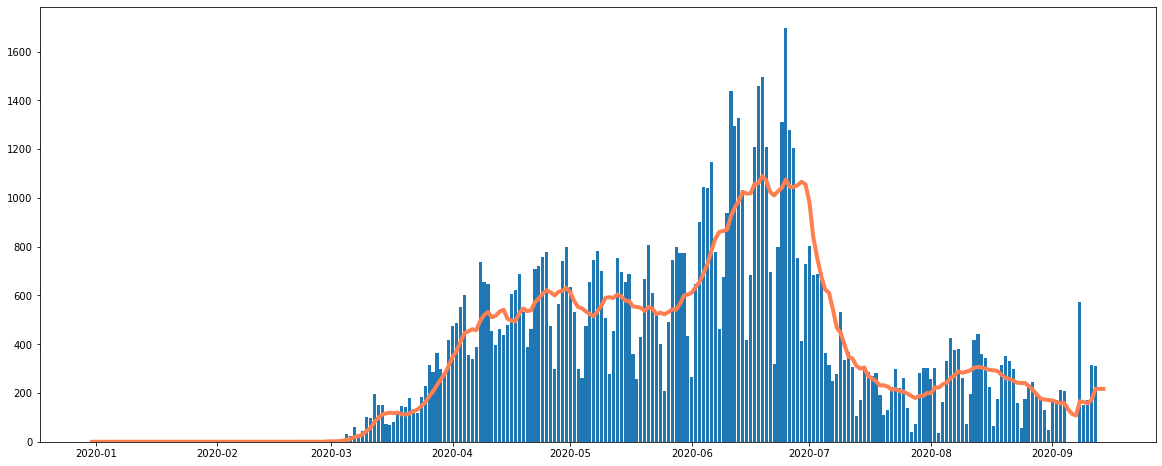

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))

country = 'Sweden'
x = owid_base[owid_base['country']==country].set_index('date').index
y = owid_base[owid_base['country']==country].set_index('date')['new_cases']

ax.bar(x, y)
ax.plot(x, y.rolling('7d').mean(), c='coral', lw=4)

In [24]:
logger.info('Saving base OWID dataset --> %s' % base_owid_dataset)

owid_base.to_pickle(base_owid_dataset)
owid_base.shape, owid_base.date.max()

2020-09-15 09:16:21.205 | INFO     | __main__:<module>:1 - Saving base OWID dataset --> ../../data/base_owid.pkl


((42838, 10), Timestamp('2020-09-14 00:00:00'))

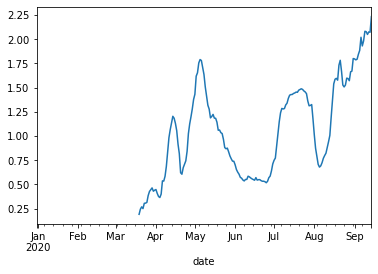

In [25]:
owid[owid['country']=='Ireland'].set_index('date')['new_tests_per_thousand'].rolling('7d').mean().plot()

In [26]:
owid.filter(like='test')

,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,tests_units
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
43182,969.0,107414.0,7.227,0.065,649.0,0.044,5.743,tests performed
43183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
